In [ ]:
!pip install tensorflow==2.6.0
import tensorflow as tf
print(tf.__version__)

In [ ]:
!pip install tensorflow==2.6.0 keras==2.6.0

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import metrics
import tensorflow as tf
from tensorflow.keras.models import load_model

# 데이터 경로
train_dir = '/content/drive/MyDrive/data2_1frame_rename/train'
val_dir = '/content/drive/MyDrive/data2_1frame_rename/val'

# 이미지 크기 및 채널
img_size = (224, 224)
img_channel = 3

# 이미지 데이터 전처리
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    brightness_range=(0.8,1.8),
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical') # categorical, binary, sparse 선택

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical') # categorical, binary, sparse 선택

# 저장된 모델 불러오기
model = load_model('/content/drive/MyDrive/ResNet101_All.h5')

# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', metrics.Precision(), metrics.Recall()])

# 스케줄러 함수 정의
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# 학습률 스케줄링 콜백 설정
lr_scheduler = LearningRateScheduler(scheduler)

# 체크포인트를 저장할 경로
checkpoint_filepath = '/content/drive/MyDrive/checkpoint/checkpoints/model-{epoch:03d}.h5'

# 체크포인트 콜백 설정
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True, # 가장 성능이 좋은 가중치 저장 여부
    save_weights_only=True, # 모델, 가중치 저장 선택
    verbose=1)

# 조기 종료 콜백 설정
#early_stopping_callback = EarlyStopping(
#    monitor='val_loss',
#    patience=5, # val_loss가 최소 5 epoch 동안 개선되지 않으면 학습 중단
#    restore_best_weights=True) # 가장 성능이 좋은 가중치 복원 여부

# 모델 학습
history = model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=30,
          validation_data=validation_generator,
          validation_steps=len(validation_generator),
          callbacks=[checkpoint_callback, lr_scheduler]) # 체크포인트, 조기 종료 인자 추가

Found 6598 images belonging to 16 classes.
Found 1994 images belonging to 16 classes.
Epoch 1/30
413/413 [==============================] - ETA: 0s - loss: 0.9494 - accuracy: 0.7311 - precision: 0.8219 - recall: 0.6608 
Epoch 1: val_loss improved from inf to 0.68137, saving model to /content/drive/MyDrive/checkpoint/checkpoints/model-001.h5
413/413 [==============================] - 5789s 14s/step - loss: 0.9494 - accuracy: 0.7311 - precision: 0.8219 - recall: 0.6608 - val_loss: 0.6814 - val_accuracy: 0.7974 - val_precision: 0.8095 - val_recall: 0.7844 - lr: 0.0010
Epoch 2/30
413/413 [==============================] - ETA: 0s - loss: 0.0864 - accuracy: 0.9732 - precision: 0.9757 - recall: 0.9691
Epoch 2: val_loss did not improve from 0.68137
413/413 [==============================] - 301s 729ms/step - loss: 0.0864 - accuracy: 0.9732 - precision: 0.9757 - recall: 0.9691 - val_loss: 4.4600 - val_accuracy: 0.2021 - val_precision: 0.2052 - val_recall: 0.1926 - lr: 0.0010
Epoch 3/30
413/413

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

train_dir = '/content/drive/MyDrive/dataset/train'
val_dir = '/content/drive/MyDrive/dataset/val'

img_size = (224, 224)
img_channel = 3

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    brightness_range=(0.8,1.8),
    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical') # categorical, binary, sparse 선택

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical') # categorical, binary, sparse 선택

resnet = ResNet50(input_shape=(img_size[0], img_size[1], img_channel), weights=None, include_top=False) # 가중치 체크포인트 파일을 불러오므로 None으로 설정

x = resnet.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
predictions = layers.Dense(16, activation='softmax')(x) # 클래스 개수만큼 조정

model = models.Model(inputs=resnet.input, outputs=predictions)

# 이전에 저장된 모델 가중치 불러오기
model.load_weights('/content/drive/MyDrive/checkpoints/model-029.h5') # 경로 작성

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

checkpoint_filepath = '/content/drive/MyDrive/checkpoints2-1/model-{epoch:03d}.h5'

checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)

# 학습 이어서 시작
history = model.fit(train_generator,
          steps_per_epoch=len(train_generator),
          epochs=30,
          validation_data=validation_generator,
          validation_steps=len(validation_generator),
          callbacks=[checkpoint_callback, early_stopping_callback],
          initial_epoch=29) # initial_epoch = 이전에 중단된 epoch 숫자

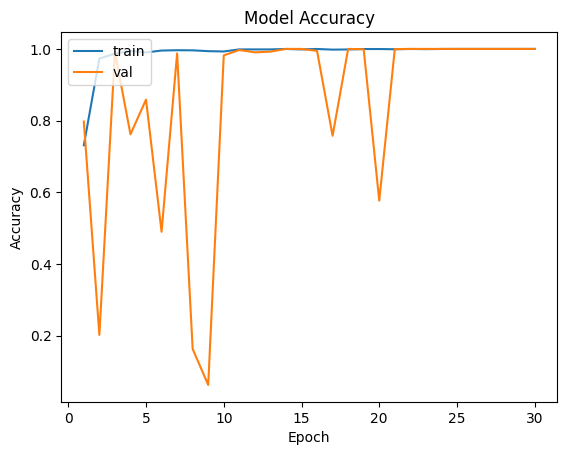

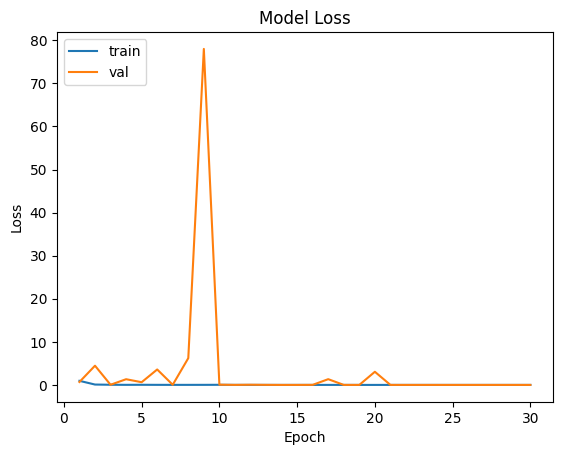

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 학습 곡선 그리기
num_epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, num_epochs + 1)

plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

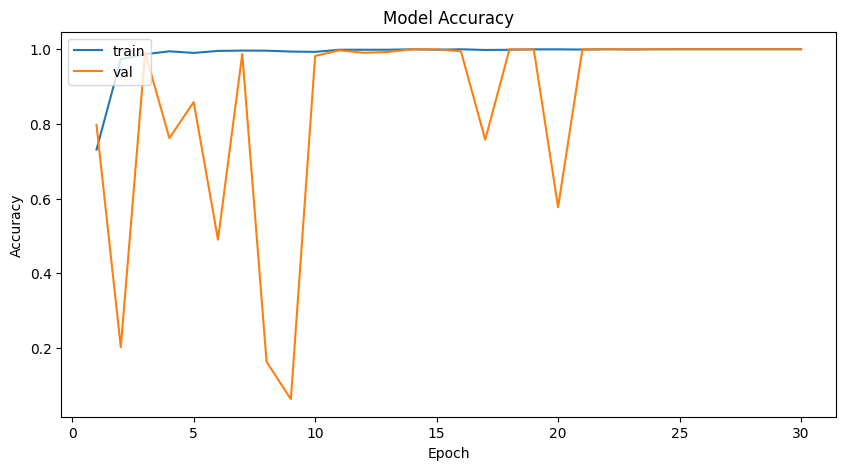

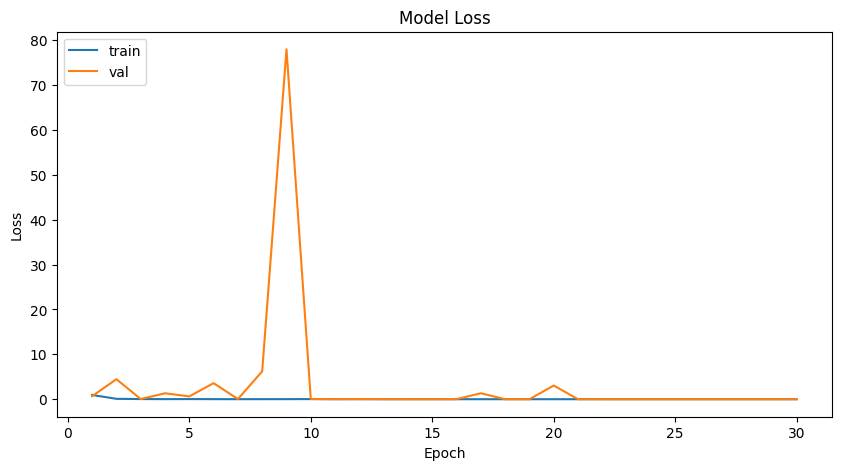

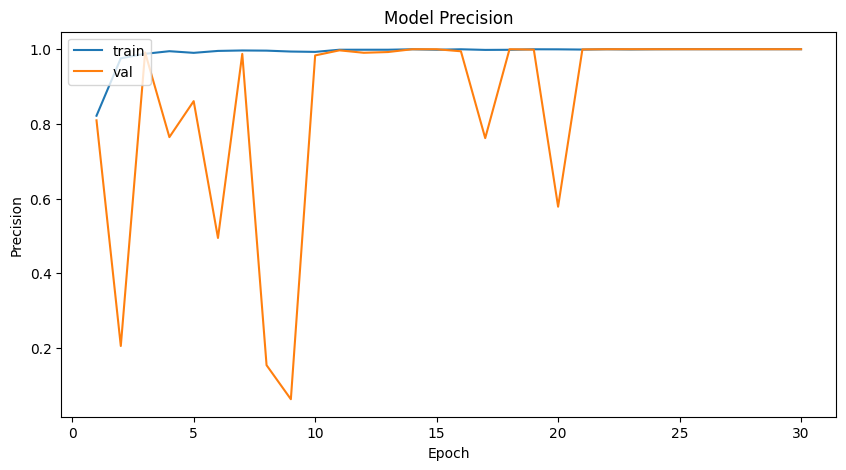

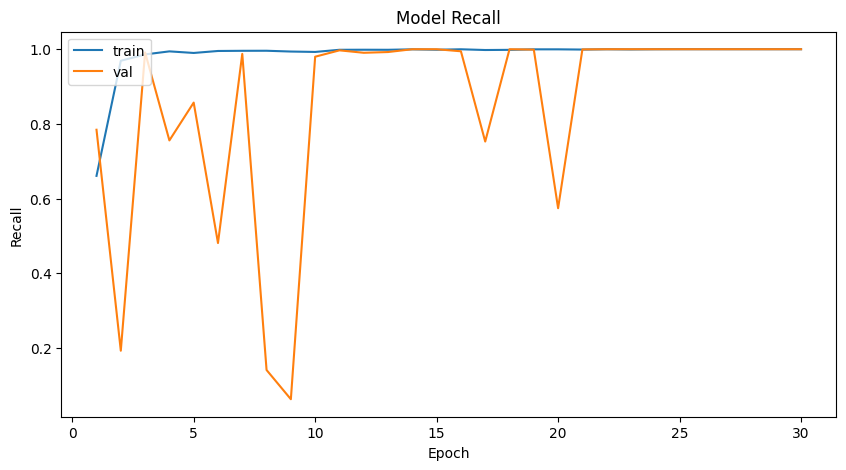

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 학습 곡선 그리기
num_epochs = len(history.history['accuracy'])
epoch_range = np.arange(1, num_epochs + 1)

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, history.history['accuracy'])
plt.plot(epoch_range, history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, history.history['loss'])
plt.plot(epoch_range, history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, history.history['precision'])
plt.plot(epoch_range, history.history['val_precision'])
plt.title('Model Precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(epoch_range, history.history['recall'])
plt.plot(epoch_range, history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [5]:
# 구글 드라이브에 모델 저장
model.save('/content/drive/MyDrive/ResNet101_All_data2_1frame.h5')

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# 4월에 새로 찍은 전체 데이터 세트 중 테스트 데이터 폴더 경로
test_dir = '/content/drive/MyDrive/data2_1frame_rename/test'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet101_All_data2_1frame.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

Found 1015 images belonging to 16 classes.
1015/1015 [==============================] - 712s 700ms/step
테스트 결과
---------------------
back_left/back_left1182.jpg : back_left
back_left/back_left1183.jpg : back_left
back_left/back_left1184.jpg : back_left
back_left/back_left1185.jpg : back_left
back_left/back_left1186.jpg : back_left
back_left/back_left1187.jpg : back_left
back_left/back_left1188.jpg : back_left
back_left/back_left1189.jpg : back_left
back_left/back_left1190.jpg : back_left
back_left/back_left1191.jpg : back_left
back_left/back_left1192.jpg : back_left
back_left/back_left1193.jpg : back_left
back_left/back_left1194.jpg : back_left
back_left/back_left1195.jpg : back_left
back_left/back_left1196.jpg : back_left
back_left/back_left1197.jpg : back_left
back_left/back_left1198.jpg : back_left
back_left/back_left1199.jpg : back_left
back_left/back_left1200.jpg : back_left
back_left/back_left1201.jpg : back_left
back_left/back_left1202.jpg : back_left
back_left/back_left1203.jpg

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# 4월에 찍은 테스트 데이터 폴더 경로
test_dir = '/content/drive/MyDrive/testdata_rename'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet101_All_data2_1frame.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):jeau
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

Found 2909 images belonging to 16 classes.
2909/2909 [==============================] - 1958s 673ms/step
테스트 결과
---------------------
back_left/back_left_test/back_left1248.jpg : back_left
back_left/back_left_test/back_left1252.jpg : back_left
back_left/back_left_test/back_left1262.jpg : back_left
back_left/back_left_test/back_left1263.jpg : back_left
back_left/back_left_test/back_left1268.jpg : back_left
back_left/back_left_test/back_left1269.jpg : back_left
back_left/back_left_test/back_left1274.jpg : back_left
back_left/back_left_test/back_left1288.jpg : back_left
back_left/back_left_test/back_left1304.jpg : back_left
back_left/back_left_test/back_left1308.jpg : back_left
back_left/back_left_test/back_left1337.jpg : right
back_left/back_left_test/back_left1350.jpg : right
back_left/back_left_test/back_left1357.jpg : right
back_left/back_left_test/back_left1360.jpg : right
back_left/back_left_test/back_left1361.jpg : right
back_left/back_left_test/back_left1376.jpg : back_left
back_l

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt

# 3월에 찍은 전체 데이터 세트 중 테스트 데이터 폴더 경로
test_dir = '/content/drive/MyDrive/dataset/test'

image_size = (224, 224)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=1,
    shuffle=False,
    class_mode='categorical')

# 저장된 모델 경로
model = load_model('/content/drive/MyDrive/ResNet101_All_data2_1frame.h5')

# 분류 및 평가
Y_pred = model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(Y_pred, axis=1)

true_labels = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 출력
print('테스트 결과')
print('---------------------')
for i, filename in enumerate(test_generator.filenames):
    print('{} : {}'.format(filename, class_labels[y_pred[i]]))

accuracy = accuracy_score(true_labels, y_pred)
precision = precision_score(true_labels, y_pred, average='macro')
recall = recall_score(true_labels, y_pred, average='macro')
f1score = f1_score(true_labels, y_pred, average='macro')

print('---------------------')
print('정확도 : {:.5f}'.format(accuracy))
print('정밀도 : {:.5f}'.format(precision))
print('재현율 : {:.5f}'.format(recall))
print('F1-score : {:.5f}'.format(f1score))

Found 1301 images belonging to 16 classes.
1301/1301 [==============================] - 971s 745ms/step
테스트 결과
---------------------
back_left/back_left103.jpg : back_left_left
back_left/back_left120.jpg : back_left_left
back_left/back_left121.jpg : back_left_left
back_left/back_left122.jpg : back_left_left
back_left/back_left145.jpg : back_left_left
back_left/back_left158.jpg : back_left
back_left/back_left182.jpg : back_left
back_left/back_left184.jpg : back_left
back_left/back_left186.jpg : back_left
back_left/back_left191.jpg : back_left
back_left/back_left21.jpg : back_left
back_left/back_left214.jpg : right_chopping
back_left/back_left234.jpg : right_chopping
back_left/back_left236.jpg : right_chopping
back_left/back_left241.jpg : back_left_right
back_left/back_left250.jpg : right_chopping
back_left/back_left261.jpg : right_chopping
back_left/back_left283.jpg : right_chopping
back_left/back_left294.jpg : right_chopping
back_left/back_left296.jpg : right_chopping
back_left/back_le